## Analysis

In this notebook, you will learn how to interpret the light curve of a start.

Requisites:
* a working Python 3.x environment, with **Astropy** (4.0), **Matplotlib** (3.1), **NumPy** (1.18), and **SciPy** (1.4) installed;
* a table with the magnitudes measured from a set of science frames (e.g. ```2022/red/mags_R.fits```).

### Let's make the light curve

We can load up the magnitudes we have previously measured and format them as an Astropy table: 

In [11]:
from astropy.io import fits
from astropy.table import Table
mags = Table(fits.open('FINAL_1/SZ_Lyn_B_wr_to_average.fits')[1].data)
print(mags)

       file           magnitude              error                time       
----------------- ------------------ --------------------- ------------------
SZ_Lyn-0001_B.fit  9.628180779323454  0.006718171682319096  2459660.321961747
SZ_Lyn-0002_B.fit  9.638575607468697 0.0068462630537947005 2459660.3232347793
SZ_Lyn-0003_B.fit  9.681137615574885  0.006719892341929542  2459660.324496503
SZ_Lyn-0004_B.fit  9.664836105883634  0.006787349268736578 2459660.3257692815
SZ_Lyn-0005_B.fit  9.689274743916384  0.006783339026000259 2459660.3270423138
SZ_Lyn-0006_B.fit   9.72273649691369  0.006710877144132368 2459660.3283153772
SZ_Lyn-0007_B.fit  9.730859362719375   0.00677216930181112   2459660.32958841
SZ_Lyn-0008_B.fit   9.72294983170468  0.006774717930012597 2459660.3308614525
SZ_Lyn-0009_B.fit  9.838272371980711  0.008432796791057382 2459660.3321344955
SZ_Lyn-0010_B.fit  9.762536295109042  0.006716981648932374 2459660.3334075385
              ...                ...                   ...      

We need to relate each magnitude value with the time of observation, which is provided in Julian Day format in the frame headers:

In [12]:
import numpy as np



Now we can properly plot the light curve of the star and save it:

(241,) (241,)


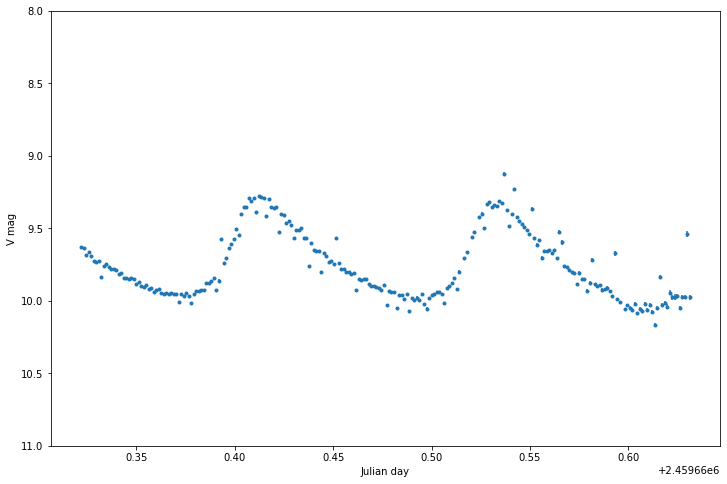

In [16]:
def setup_plot(figsize, xlabel, ylabel):
    """ @brief Initialize basic plot parameters
        @param figsize Figure size
        @param xlabel X-axis label
        @param ylabel Y-axis label
    """

    plt.figure(figsize=figsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
import matplotlib.pyplot as plt

jd=[]
mag=[]
mag_err=[]
for i in range (0, len(list(mags['magnitude']))):
    if not np.isnan(mags['magnitude'][i]):
        if not np.isnan(mags['error'][i]):
            jd.append(float(mags['time'][i]))
            mag.append(float(mags['magnitude'][i]))
            mag_err.append(float(mags['error'][i])) 
jd=np.array(jd)
mag=np.array(mag)
mag_err=np.array(mag_err)
print(mag.shape, mag_err.shape)
setup_plot((12,8), 'Julian day', 'V mag')
plt.errorbar(jd, mag, mag_err, fmt='.')
plt.ylim(11, 8)
plt.show()

t = Table([jd, mag, mag_err], names=['jd', 'V', 'V_err'])
t.write('mags_jd.fits', format='fits', overwrite=True)


Note that the time step is not constant:

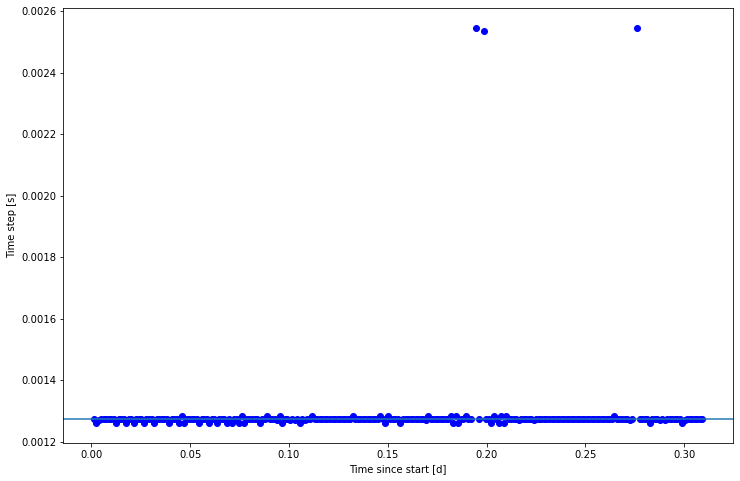

In [17]:
td = jd-jd[0]  
td_step = (td[1:]-td[:-1])
td_med = np.median(td_step)

setup_plot((12,8), 'Time since start [d]', 'Time step [s]')
plt.scatter(td[1:], td_step, c='blue')
plt.axhline(td_med)
plt.show()

## Timing the fluctuations

A simple way to measure the period is to slide the light curve over itself along the time axis. We expect that the auto-correlation to be 1 at start (before sliding the curve) and to reach a maximum at some point, when the curve has been slid by exactly one period.

We use ```pearson``` from SciPy to compute the Pearson correlation coefficient. To do so, we need to resample the light curve to an evenly-spaced time coordinate. 

Note that when the curve is slid, the region where it overlaps with the original curve shrinks down, increasing the error on the correlation coefficient.

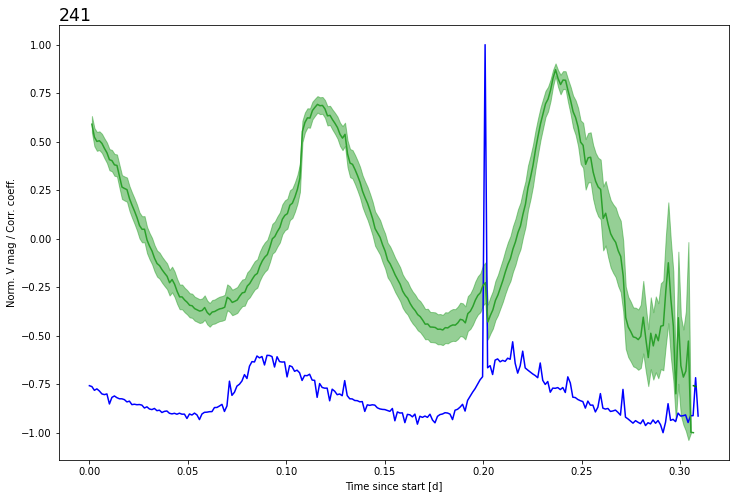

In [18]:
from IPython import display
from scipy.stats import mode, pearsonr

r = np.array([])
dr = np.array([])

mag_norm = -2*(mag-0.5*(np.nanmax(mag)+np.nanmin(mag)))/(np.nanmax(mag)-np.nanmin(mag))  # Normalized V mag (-valor medio e diviso ampiezza)

td_es = np.arange(0,np.max(td),mode(td_step)[0])  # Evenly-spaced time coordinate
mag_es = np.interp(td_es, td, mag)
mag_std_es = np.interp(td_es, td, mag_err)
mag_norm_es = np.interp(td_es, td, mag_norm)

def refresh_plot(i=None):
    """ @brief Refresh the image during iterative plot
        @param i iterative
    """
    
    if i != None:
        plt.text(x=0, y=1.0, s=i, color='black', ha='left', va='bottom', fontsize='xx-large', 
                 transform=plt.axes().transAxes)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close()

for i in range(len(td_es)-1):

    if i>0:
        rp, _ = pearsonr(mag_norm_es[i:], mag_norm_es[:-i])

        r = np.append(r, rp)  # Pearson's correlation coefficient R
        dr = np.append(dr, (1-rp**2)/np.sqrt(len(mag_norm_es[i:])-2))  # Uncertainty on R 
        setup_plot((12,8), 'Time since start [d]', 'Norm. V mag / Corr. coeff.')
        plt.plot(td, mag_norm, c='blue')
        plt.plot(td_es[i:], mag_norm_es[:-i], c='green')
        plt.plot(td_es[:i+1], r, c='C2')
        plt.fill_between(td_es[:i+1], r-dr, r+dr, color='C2', alpha=0.5)
        refresh_plot(i)
        plt.show()
    else:
        r = np.append(r, np.nan)
        dr = np.append(dr, np.nan)

The period is somewhere around 0.122 days. To better estimate it, let's zoom into that region of the plot:

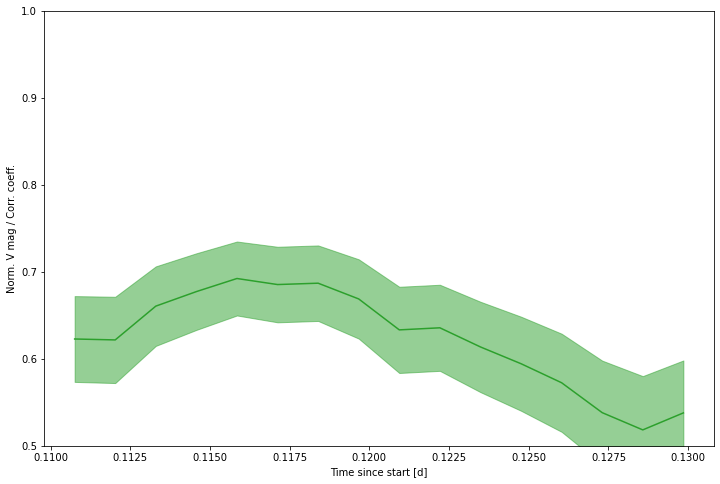

In [19]:
zoom = np.where(np.logical_and(td_es>0.110, td_es<0.130))

setup_plot((12,8), 'Time since start [d]', 'Norm. V mag / Corr. coeff.')
plt.plot(td_es[zoom], r[zoom], c='C2')
plt.fill_between(td_es[zoom], r[zoom]-dr[zoom], r[zoom]+dr[zoom], color='C2', alpha=0.5)
plt.ylim(0.5,1)
plt.show()

We can roughly take the maximum of ```r``` in this region as our estimate of the period, and the region where ```r+dr``` is greater than this value as the confidence interval for such estimate:

In [20]:
est = np.argmax(r[zoom])
ci = np.where(r[zoom]+dr[zoom]>r[zoom][est])

period = td_es[zoom][est]
period_lo = td_es[zoom][ci][0] - period
period_up = td_es[zoom][ci][-1] - period
print('Period: %3.4f (%3.4f +%3.4f) d' % (period, period_lo, period_up))

Period: 0.1158 (-0.0025 +0.0038) d


This is in agreement with the current best estimate of 0.12053492 d, albeit a lot less precise. We could have modeled the peak of the correlation coefficient in a more sophisticated way, but the better way to improve the estimation is to observe the star through several periods instead of one.

## Folding our data

An efficient technique to analize periodic data when the series is limited in time is to **fold** the time series onto itself, i.e. converting times into phases. If we don't know the period, we can try and compute different phase series for different test periods in a range, and see which folding gives a better alignment of the features of the phase series (not surprisingly, this happens for a period around 0.12 d in our case):

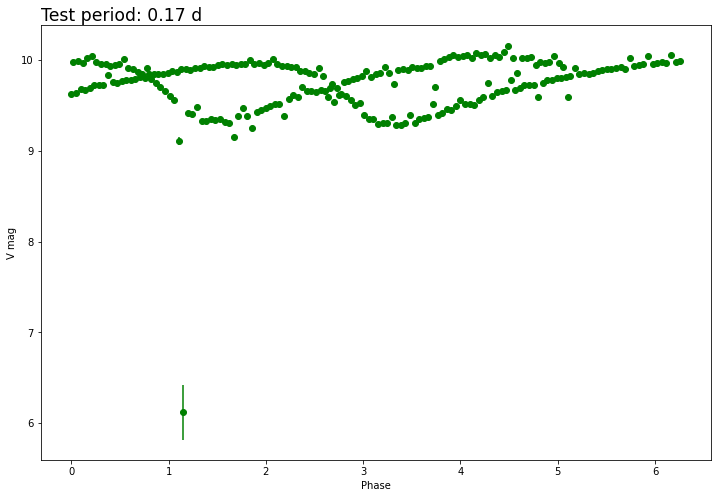

In [21]:
import time

td_ph = td_es
mag_ph = mag_es
mag_std_ph = mag_std_es

period_range = np.arange(0.01,0.175,0.01)  # Range of test periods


for i,p in enumerate(period_range):
    ph = 2*np.pi * td_ph/p % (2*np.pi)
    setup_plot((12,8), 'Phase', 'V mag')
    plt.errorbar(ph, mag_ph, yerr=mag_std_ph, fmt='o', color='green')
    refresh_plot("Test period: %3.2f d" % p)
    time.sleep(0.5)
    plt.show()

We can refine our estimation of the period by scanning the range of test periods around the value that gives the best folding alignment, and computing the **reduced chi-squared** ($\chi^2_r$) between the sections of the phase series that are folded onto each other. We see that $\chi^2_r$ decreases, reaches a minimum very close to 1, and increases again, as the test periods moves through the range:

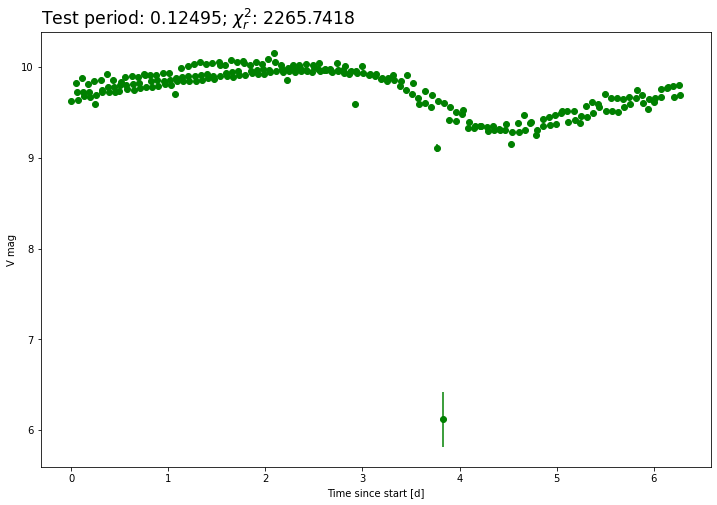

In [22]:
bins = 210

def chi2r(obs, mod, err, npar=1):
    """ @brief Compute the reduced chi square
        @param obs Observed data
        @param mod Model data
        @param err Error on observed data
        @param npar Number of model parameters
    """
    
    chi2 = np.sum((obs-mod)**2/err**2)
    return chi2 /(obs.size-npar)


period_range = np.arange(0.115,0.125,0.00005)  # Shorter and finer range of test periods
period_chi2r = np.array([])

for p in period_range:
    ph = 2*np.pi * td_ph/p % (2*np.pi)
    
    head_sel = td_ph//p==0
    tail_sel = td_ph//p==1
    if len(head_sel)!=len(tail_sel):
        break
    l = len(head_sel)
    head = mag_ph[head_sel]
    tail = np.interp(ph[head_sel], ph[tail_sel], mag_ph[tail_sel])
    print(tail.shape)
    print(len(mag_ph))
    err = mag_std_ph[head_sel]
    period_chi2r = np.append(period_chi2r, chi2r(head,tail,err))
    
    setup_plot((12,8), 'Time since start [d]', 'V mag')
    plt.errorbar(ph, mag_ph, yerr=mag_std_ph, fmt='o', color='green')
    
    refresh_plot(r"Test period: %3.5f; $\chi_r^2$: %3.4f" % (p, chi2r(head,tail,err)))
    plt.show()
    #time.sleep(0.5)

The best-fit period is the one that gives the minimum $\chi_r^2$ on the phase series, and its 1-$\sigma$ uncertainty is defined by the region where the $\chi_r^2$ is less than $\chi_{r,\mathrm{min}}^2+1$. You can see that with this method we obtain a much better precision than using the Pearson correlation coefficient, as we did before: 

[0.11615 0.1162  0.11625 0.1163  0.11635 0.1164  0.11645 0.1165  0.11655
 0.1166  0.11665 0.1167  0.11675 0.1168  0.11685 0.1169  0.11695 0.117
 0.11705 0.11715 0.1172  0.11725 0.1173  0.11735 0.1174  0.11745 0.1175
 0.11755 0.1176  0.11765 0.1177  0.11775 0.1178  0.11785 0.1179  0.11795
 0.118   0.11805 0.1181  0.11865 0.1187  0.11875 0.1188  0.11885 0.1189
 0.11895 0.119   0.11905 0.1191  0.11915 0.1192  0.11925 0.1193  0.11935
 0.1194  0.11945 0.1195  0.11955 0.1196  0.11965 0.1197  0.11975 0.1198
 0.11985 0.1199  0.11995 0.12    0.12005 0.1201  0.12015 0.1202  0.12025
 0.1203  0.12035 0.1204  0.12045 0.1205  0.12055 0.1206  0.12065 0.1207
 0.12075 0.1208  0.12085 0.1209  0.12095 0.121   0.12105 0.1211  0.12115
 0.1212  0.12125 0.1213  0.12135 0.1214  0.12145 0.1215  0.12155 0.1216
 0.12165 0.1217  0.12175 0.1218  0.12185 0.1219  0.12195 0.122   0.12205
 0.1221  0.12215 0.1222  0.12225 0.1223  0.12235 0.1224  0.12245 0.1225
 0.12255 0.1226  0.12265 0.1227  0.12275 0.1228  0.12285 0.

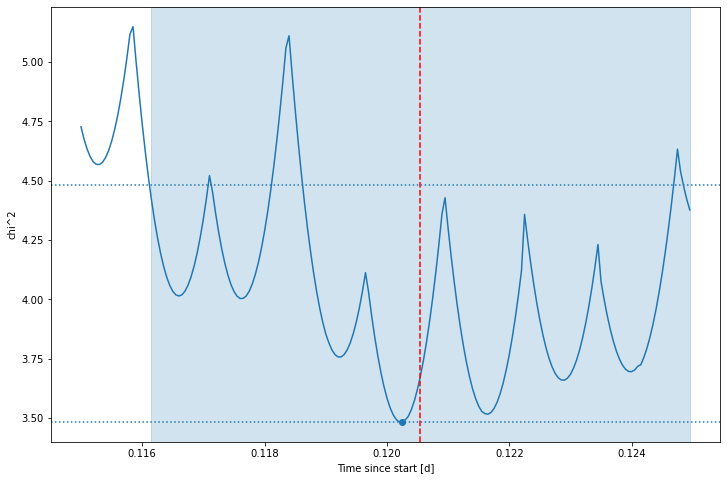

Period: 0.12025 (-0.00410 +0.00470) d


In [91]:
est = np.argmin(period_chi2r)
ci = np.where(period_chi2r<period_chi2r[est]+1)

chi2r_min = period_chi2r[est]
period = period_range[est]

period_lo = period_range[ci][0] - period
period_up = period_range[ci][-1] - period

setup_plot((12,8), 'Time since start [d]', 'chi^2')
plt.plot(period_range, period_chi2r)
plt.scatter(period, period_chi2r[est])
plt.axhline(chi2r_min, linestyle=':')
plt.axhline(chi2r_min+1, linestyle=':')
plt.axvline(0.12053492, linestyle='--', c='r')  # Best-fit period from literature 
plt.axvspan(period+period_lo, period+period_up, alpha=0.2, color='C0')
plt.show()

print('Period: %3.5f (%3.5f +%3.5f) d' % (period, period_lo, period_up))

> **Your turn now**: review the reduction and photometry (notebooks ```reduction.ipynb``` and ```photometry.ipynb```) to solve problems with individual frames and improve the analysis